In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


In [3]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [4]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
beta = 0.5

In [5]:
dataset = datasets.CIFAR10(root="./Dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


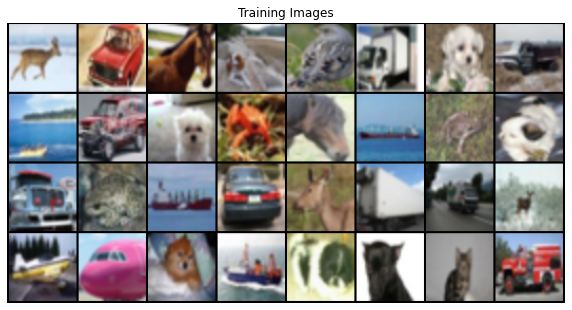

In [6]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.savefig('Results/DCGAN_Real.jpg', format='jpeg', dpi=100, bbox_inches='tight')
plt.show()


In [7]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        # Initial convolutional layer
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img,        # Number of input channels (e.g., 3 for RGB images)
                features_d,          # Number of output channels (features) for this layer
                kernel_size=4,       # Kernel size
                stride=2,            # Stride for convolution
                padding=1            # Padding for convolution
            ),
            nn.LeakyReLU(0.2),      # Leaky ReLU activation function with negative slope of 0.2
            
            # Downsample layers
            self.Dnet(features_d, features_d * 2, 4, 2, 1),    # 1st downsample block
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  # 2nd downsample block
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  # 3rd downsample block
            
            # Final convolutional layer
            nn.Conv2d(
                features_d * 8,  # Number of input channels from the last downsample block
                1,               # Output channel size (1 for binary classification)
                kernel_size=4,   # Kernel size
                stride=2,        # Stride for convolution
                padding=0        # No padding for this convolution
            ),
            nn.Sigmoid(),       # Sigmoid activation to squash the output between 0 and 1
        )

    # Helper function to create a downsample block
    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,        # No bias since we're using BatchNorm
            ),
            nn.LeakyReLU(0.2),    # Leaky ReLU activation function with negative slope of 0.2
        )

    # Forward method to pass input through the discriminator network
    def forward(self, x):
        return self.disc(x)


In [8]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [9]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN Source paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [10]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [11]:
# Initialize Adam optimizer for the Generator
optimGenerator = optim.Adam(
    gen.parameters(),          # Generator parameters to optimize
    lr=LEARNING_RATE,          # Learning rate
    betas=(beta, 0.999)        # Beta parameters for Adam optimizer
)
# Initialize Adam optimizer for the Discriminator
optimDiscriminator = optim.Adam(
    disc.parameters(),         # Discriminator parameters to optimize
    lr=LEARNING_RATE,          # Learning rate
    betas=(beta, 0.999)        # Beta parameters for Adam optimizer
)
# Binary Cross Entropy Loss function
criterion = nn.BCELoss()
# Generate fixed noise for visualization during training
fixed_noise = torch.randn(
    32,                        # Batch size
    NOISE_DIM,                 # Dimension of noise vector
    1,                         # Height
    1                          # Width
).to(device)                   # Move tensor to device (GPU or CPU)
# Initialize step counter for tracking iterations
step = 0


In [12]:
gen.train(),disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [13]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = models.inception_v3(pretrained=True)

        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

# Choose the block index corresponding to final average pooling features
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model = model.cuda()


In [14]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048,
                                    cuda=False):
    """
    Calculate the activation statistics (mean and covariance) for a set of images
    using a given model.
    
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize an empty array to store the activations
    act = np.empty((len(images), dims))
    
    # Move images to GPU if cuda flag is set
    if cuda:
        batch = images.cuda()
    else:
        batch = images
    
    # Get the activations from the model's forward pass
    pred = model(batch)[0]
    
    # If the spatial dimensions are not 1x1, perform adaptive average pooling
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))
    
    # Convert activations to numpy array and reshape
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    # Calculate mean and covariance of the activations
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    
    return mu, sigma


In [15]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Calculate the Frechet distance between two multivariate Gaussians
    defined by mean and covariance.

    """
    
    # Ensure mu1 and mu2 are 1-dimensional arrays
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    # Ensure sigma1 and sigma2 are 2-dimensional arrays
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Check shapes of mu1, mu2, sigma1, and sigma2
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    # Compute the difference between means
    diff = mu1 - mu2

    # Compute the square root of the product of covariances
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Check if covmean is finite
    if not np.isfinite(covmean).all():
        # Add epsilon to the diagonal of covariances if not finite
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Check for complex numbers in covmean
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    # Compute the trace of the covmean
    tr_covmean = np.trace(covmean)

    # Compute the Frechet distance
    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


In [16]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [17]:
# Initialize lists to store losses and images
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
iters = 0

print("!!Training Started!!")

# Start timing
time_start = time.time() 

for epoch in range(NUM_EPOCHS):
    epoch = epoch + 1
    
    for batch_idx, data in enumerate(dataloader, 0):
        # Training with real batch
        real = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        
        # Generate fake images
        fake = gen(noise)

        # Calculate loss for real and fake images
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Overall discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        # Generator loss
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()
        
        # Store losses
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        # Save generator's output on fixed noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    
    # Calculate and store FID
    fretchet_dist = calculate_fretchet(real, fake, model)
    FID_list.append(fretchet_dist)
    
    # Print training progress
    if epoch % 5 == 0:
        print(f'\nEpoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} '
              f'Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f} FID:{fretchet_dist:.3f}')
    
    # Save generated and real images
    images = gen(fixed_noise)
    if not os.path.exists('Results/DCGAN_FAKE'):
        os.makedirs('Results/DCGAN_FAKE')
    if not os.path.exists('Results/DCGAN_REAL'):
        os.makedirs('Results/DCGAN_REAL')
    utils.save_image(images.detach(), 'Results/DCGAN_FAKE/DCGAN50_epoch_%03d.png' % (epoch), normalize=True)
    utils.save_image(real.detach(), 'Results/DCGAN_REAL/DCGAN50_epoch_%03d.png' % (epoch), normalize=True)
        
time_end = time.time()
print('\n\nElapsed time: %.2f s.' % (time_end - time_start))


!!Training Started!!

Epoch [5/40] Batch 1562/1563 Loss Discriminator: 0.646, loss Generator: 0.980 FID:318.600

Epoch [10/40] Batch 1562/1563 Loss Discriminator: 0.559, loss Generator: 0.843 FID:275.665

Epoch [15/40] Batch 1562/1563 Loss Discriminator: 0.628, loss Generator: 0.812 FID:282.989

Epoch [20/40] Batch 1562/1563 Loss Discriminator: 0.621, loss Generator: 1.043 FID:267.834

Epoch [25/40] Batch 1562/1563 Loss Discriminator: 0.493, loss Generator: 1.136 FID:269.514

Epoch [30/40] Batch 1562/1563 Loss Discriminator: 0.548, loss Generator: 1.110 FID:257.412

Epoch [35/40] Batch 1562/1563 Loss Discriminator: 0.489, loss Generator: 1.043 FID:292.816

Epoch [40/40] Batch 1562/1563 Loss Discriminator: 0.490, loss Generator: 1.027 FID:264.333


Elapsed time: 4130.84 s.


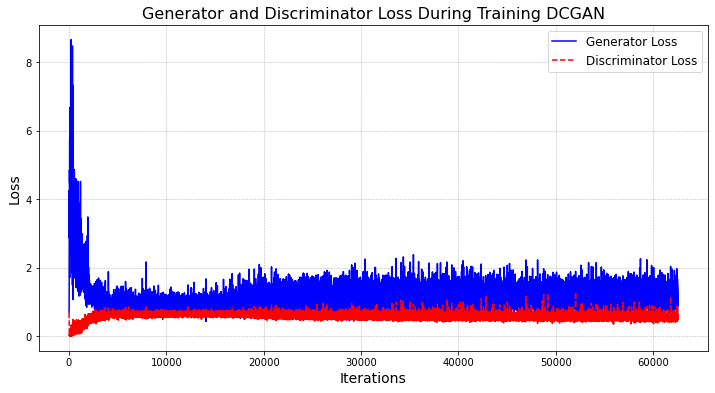

In [29]:
# Check if directory exists, if not create it
if not os.path.exists('Results/Loss_Data'):
    os.makedirs('Results/Loss_Data')

# Saving the loss data
np.save('Results/Loss_Data/DCGAN_GLoss', GenLoss) 
np.save('Results/Loss_Data/DCGAN_DLoss', DiscLoss) 

# Loading the loss data
GenLoss = np.load('Results/Loss_Data/DCGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/DCGAN_DLoss.npy')

# Plotting
plt.figure(figsize=(12, 6))

# Generator Loss
plt.plot(GenLoss, label="Generator Loss", color='blue', linestyle='-', linewidth=1.5)

# Discriminator Loss
plt.plot(DiscLoss, label="Discriminator Loss", color='red', linestyle='--', linewidth=1.5)

# Title and labels
plt.title("Generator and Discriminator Loss During Training DCGAN", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Grid and legend
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(loc="upper right", fontsize=12)

# Save and show plot
plt.savefig('Results/DCGAN_Loss.pdf', format='png', dpi=300, bbox_inches='tight')
plt.show()


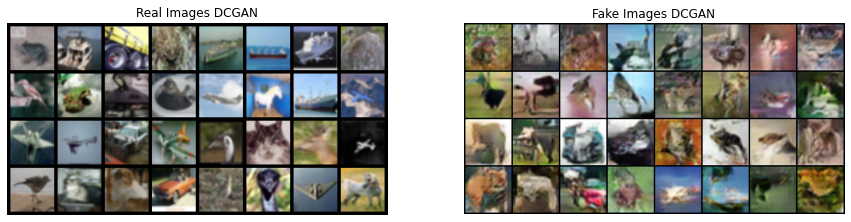

In [26]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images DCGAN")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images DCGAN")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('Results/DCGAN_BEST.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

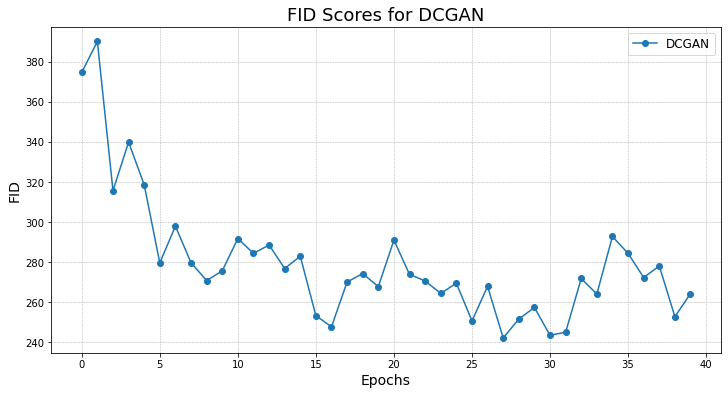

In [28]:
plt.figure(figsize=(12, 6))

# Plot FID scores
plt.plot(FID_list, label="DCGAN", marker='o', linestyle='-')

# Title and labels
plt.title("FID Scores for DCGAN", fontsize=18)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("FID", fontsize=14)

# Legend
plt.legend(fontsize=12)

# Grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.savefig('Results/DCGAN_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [22]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/DC_FID', FID_list) 

In [23]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(1.0853056, 0.57042545, 0.4292317, 0.0029210465, 1.0267991, 0.48974144)

In [24]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-1]

(242.19727374205524, 390.10355616240514, 279.73930227400643, 264.3328011554606)